In [10]:
import os
import sys
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import keras.backend as K
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.regularizers import l1_l2
from sklearn.metrics import accuracy_score
from collections import OrderedDict, Counter
from tensorflow.python.ops import gen_array_ops
from keras.layers import Dense, Dropout, Flatten
from names import Names as n

In [11]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 10000)
pd.set_option('display.max_colwidth', None)
matplotlib.use("tkagg")
%matplotlib inline

In [23]:
def training_progress(fitted_model, metrics, num_plots, loss_name, plot_val=None):
    '''
    A function for plotting the model history by showing the metric and loss throughout training
    '''
    plt.subplot(1, num_plots, 2)
    plt.plot(fitted_model.history['loss'], label='train loss')
    if plot_val is not None:
        plt.plot(fitted_model.history['val_loss'], label='val loss')
    plt.title('Loss ({})'.format(loss_name))
    plt.legend()

    for i, metric in enumerate(metrics):
        subplot_number = i + 3
        plt.subplot(1, num_plots, subplot_number)
        plt.plot(fitted_model.history[metric], label=str(metric))
        if plot_val is not None:
            plt.plot(fitted_model.history[f'val_{metric}'], label=f'val_{metric}')
        plt.title(str(metric))
        plt.legend()

    plt.show()


def plot_model_result(model, fitted_model, metrics, X, loss_name, plot_val=None):
    '''
    plot the foe_probabilities of a model
    plot the training history
    show training accuracy
    '''
    num_plots = len(metrics) + 2
    probas = model.predict_proba(X)
    plt.figure(figsize=(15, 5))
    plt.subplot(1, num_plots, 1)
    plt.hist(probas)
    plt.xlabel('predict_proba')
    training_progress(fitted_model, metrics, num_plots, loss_name, plot_val)

## Read in Data

In [15]:
df = pd.read_csv("models/cfu_neural_network/df_for_testing.csv")
display(df)

,FSC-A,FSC-H,FSC-W,SSC-A,SSC-H,SSC-W,inducer_concentration,timepoint,label,percent_live
0,4.937493,4.852639,1.612784,4.545703,4.432199,1.477121,0.0,0.5,1.0,39.67
1,4.881054,4.769717,1.591065,4.593319,4.483273,1.491362,0.0,0.5,1.0,39.67
2,5.217273,5.056962,1.716003,5.115637,4.985498,1.662758,0.0,0.5,1.0,39.67
3,4.837431,4.795463,1.568202,4.394942,4.333971,1.397940,0.0,0.5,1.0,39.67
4,5.224023,4.771183,1.977724,4.895577,4.490436,1.838849,0.0,0.5,1.0,39.67
...,...,...,...,...,...,...,...,...,...,...
259537,4.086538,3.939769,0.000000,4.006380,3.955592,0.000000,80.0,6.0,0.0,0.00
259538,6.020599,5.369036,3.009876,6.020599,6.020599,3.009876,80.0,6.0,0.0,0.00
259539,3.429591,3.334454,0.000000,3.146438,2.997386,0.000000,80.0,6.0,0.0,0.00
259540,3.640680,3.509337,0.000000,3.005181,2.911690,0.000000,80.0,6.0,0.0,0.00


In [5]:
# for x in flow_channels:
#     print(df[x].max())

In [19]:
flow_channels = n.morph_cols.copy()

def plot_flow_channels(df, conc, tp):
    sub_df = df.loc[(df[n.inducer_concentration] == conc) & (df[n.timepoint] == tp)]
    
    fig = plt.figure(figsize=(30, 5))
    fig.suptitle("{} = {}, {} = {}".format(n.inducer_concentration, conc, n.timepoint, tp), fontsize=16)

    for i, channel in enumerate(flow_channels):
        plt.subplot(1, len(flow_channels), i+1)
        plt.hist(sub_df[channel])
        plt.title(channel)
        plt.xlim(0, 6.5)
    plt.show()

In [7]:
# for conc in df[n.inducer_concentration].unique():
#     for tp in df[n.timepoint].unique():
#         plot_flow_channels(df, conc, tp)

In [8]:
df_0s = df.copy()
df_1s = df.copy()
df_0s = df_0s.loc[df_0s[n.label] == 0]
df_1s = df_1s.loc[df_1s[n.label] == 1]

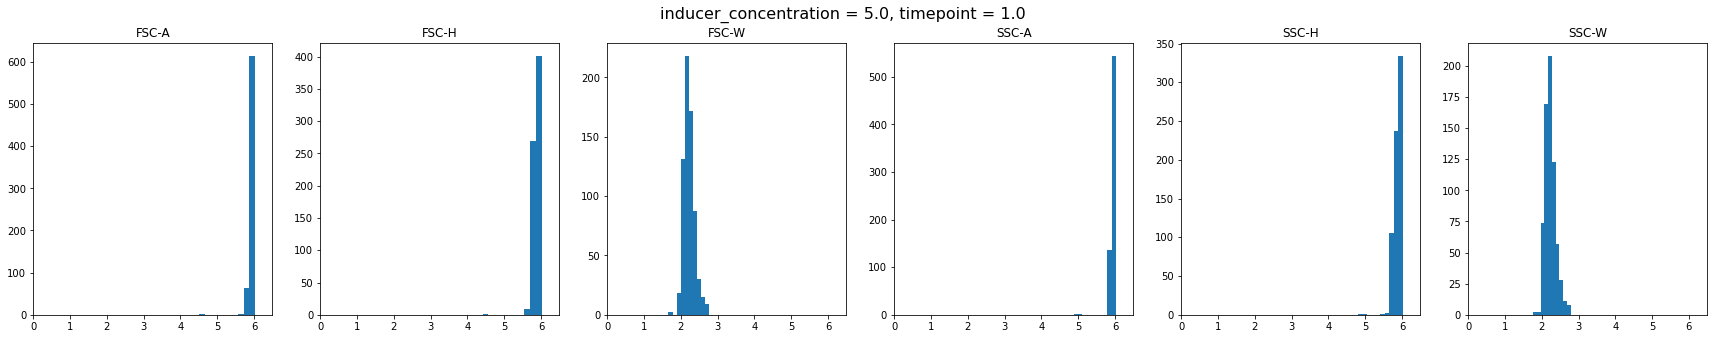

In [9]:
plot_flow_channels(df=df_0s, conc=5.0, tp=1.0)

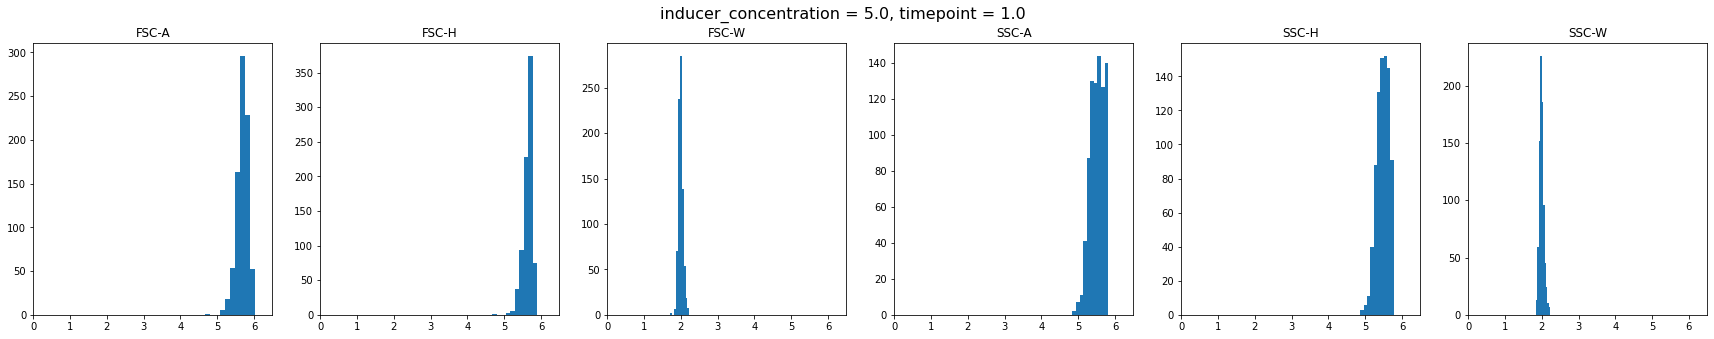

In [10]:
plot_flow_channels(df=df_1s, conc=5.0, tp=1.0)

In [17]:
df_5_1 = df.copy()
df_5_1 = df_5_1.loc[(df_5_1[n.inducer_concentration] == 5.0) & (df_5_1[n.timepoint] == 1.0)]
display(df_5_1)

,FSC-A,FSC-H,FSC-W,SSC-A,SSC-H,SSC-W,inducer_concentration,timepoint,label,percent_live
52725,5.80461,5.76281,2.04922,5.55417,5.51251,2.04922,5.0,1.0,1.0,59.256667
52726,5.74804,5.68753,1.97313,5.60107,5.53544,2.02938,5.0,1.0,1.0,59.256667
52727,6.02060,5.96847,2.43933,6.02060,6.02060,2.46687,5.0,1.0,0.0,59.256667
52728,6.02060,5.87752,2.24055,6.02060,5.95239,2.25285,5.0,1.0,0.0,59.256667
52729,5.79739,5.75933,2.06819,5.34844,5.32800,2.02938,5.0,1.0,1.0,59.256667
...,...,...,...,...,...,...,...,...,...,...
54220,5.45815,5.46314,1.91381,5.40162,5.40888,1.91908,5.0,1.0,1.0,59.256667
54221,6.02060,5.89751,2.19312,6.02060,6.01726,2.21748,5.0,1.0,0.0,59.256667
54222,5.65810,5.65752,1.91381,5.42054,5.42660,1.91381,5.0,1.0,1.0,59.256667
54223,6.02060,5.91843,2.42488,6.02060,5.86076,2.43775,5.0,1.0,0.0,59.256667


In [12]:
from pathlib import Path
from harness.test_harness_class import TestHarness
from harness.th_model_instances.hamed_models.random_forest_classification import random_forest_classification
from harness.th_model_instances.hamed_models.weighted_logistic import weighted_logistic_classifier


In [13]:
th = TestHarness(output_location=Path("__file__"))
th.run_custom(function_that_returns_TH_model=random_forest_classification,
              dict_of_function_parameters={},
              training_data=df_5_1,
              testing_data=df_5_1,
              description="asdf",
              target_cols=n.label,
              feature_cols_to_use=flow_channels,
              index_cols=list(df_5_1.columns.values),
              normalize=False,
              feature_cols_to_normalize=flow_channels,
              feature_extraction=False)


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 09:39:19
Starting Classification training...
Training time was: 0.83 seconds
Testing time was: 0.22 seconds
Run finished at 09:39:20. Total run time = 1.32 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^




In [14]:
th = TestHarness(output_location=Path("__file__"))
th.run_custom(function_that_returns_TH_model=weighted_logistic_classifier,
              dict_of_function_parameters={},
              training_data=df_5_1,
              testing_data=df_5_1,
              description="asdf",
              target_cols=n.label,
              feature_cols_to_use=flow_channels,
              index_cols=list(df_5_1.columns.values),
              normalize=False,
              feature_cols_to_normalize=flow_channels,
              feature_extraction=False)


----------------------------------------------------------------------------------------------------
Starting run of model weighted_logistic_classifier at time 09:39:20
Starting Classification training...
Training time was: 1.30 seconds
Testing time was: 0.01 seconds
Run finished at 09:39:21. Total run time = 1.45 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^




## Test NNs

In [3]:
def bin_cross_v0(label_conds_cfus, y_pred):
    y_pred = K.flatten(y_pred)
    y_true = label_conds_cfus[:, col_idx[n.label]]
    final_loss = tf.losses.binary_crossentropy(y_true=y_true, y_pred=y_pred)
    return final_loss

In [7]:
def single_node_model(input_shape=None, loss=bin_cross_v0, metrics=None, lr=0.1):
    if metrics is None:
        metrics = [loss]
    model = Sequential()
    model.add(Dense(units=1, activation='sigmoid', input_shape=(input_shape,)))
    model.compile(loss=loss, optimizer=Adam(lr=lr),
                  metrics=metrics, run_eagerly=True)
    return model

In [8]:
def labeling_booster_model(input_shape=None, loss="binary_cross_entropy", metrics=None, lr=0.01):
    if metrics is None:
        metrics = [loss]
    model = Sequential()
    model.add(Dropout(0.1, input_shape=(input_shape,)))
    # wr = l1_l2(l2=0.02, l1=0)
    wr = None
    model.add(Dense(units=32, activation="relu", kernel_regularizer=wr))
    model.add(Dropout(0.3))
    model.add(Dense(units=16, activation="relu", kernel_regularizer=wr))
    model.add(Dropout(0.1))
    model.add(Dense(units=8, activation="relu", kernel_regularizer=wr))
    model.add(Dropout(0.1))
    model.add(Dense(units=4, activation="relu", kernel_regularizer=wr))
    model.add(Dropout(0.1))
    # wr = l1_l2(l2=0.02, l1=0)
    model.add(Dense(units=1, activation='sigmoid', kernel_regularizer=wr))
    model.add(Flatten())
    model.compile(loss=loss, optimizer=Adam(lr=lr),
                  metrics=metrics, run_eagerly=True)
    # TODO: figure out how to add accuracy to metrics. Not trivial due to 4D nature of our Y.
    return model

In [12]:
features = n.morph_cols

def run_model(model_function, lr, loss, metrics, X, Y, epochs, batch_size, verbose, shuffle):
    # reset model each time
    tf.compat.v1.reset_default_graph
    tf.keras.backend.clear_session()
    
    # create model
    model = model_function(input_shape=len(features), loss=loss, metrics=metrics, lr=lr)
    print(model.summary())

    
    # fit model and predict
    start_time = time.time()
    fitted_model = model.fit(X, Y, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle=shuffle)
    predict_proba = model.predict(X)
    class_predictions = np.ndarray.flatten(predict_proba > 0.5).astype("int32")
    
    # print metrics
    training_accuracy = accuracy_score(y_true=Y, y_pred=class_predictions)
    print("\nModel Boosting took {} seconds".format(time.time() - start_time))
    print("Training Accuracy = {}%".format(round(100 * training_accuracy, 2)))
    print(Counter(class_predictions))
    
    # plot probabilities and losses
    plot_model_result(model=model, fitted_model=fitted_model,
                      metrics=[x for x in metrics],
                      X=X, loss_name=loss, plot_val=None)
    
#     # print summary of predictions vs. cfus
#     preds_and_labels = Y.copy()
# #     preds_and_labels.drop(columns=[n.label], inplace=True)
#     preds_and_labels[n.label] = preds_and_labels[n.label] * 100
#     preds_and_labels["nn_preds"] = class_predictions * 100
#     preds_and_labels.insert(2,"original_percent_live", original_percent_live)
#     preds_and_labels.rename(columns={"percent_live":"altered_percent_live"}, inplace=True)
#     groupby_means = preds_and_labels.groupby([n.inducer_concentration, n.timepoint]).mean()
#     print(groupby_means)
    
#     # plot percent live over conditions
#     plot_percent_live_over_conditions(groupby_means)

#     return groupby_means

In [20]:
X = df_5_1[flow_channels]
Y_labels = df_5_1[n.label]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 7         
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________
None

Model Boosting took 5.135905981063843 seconds
Training Accuracy = 54.8%
Counter({1: 1488, 0: 12})


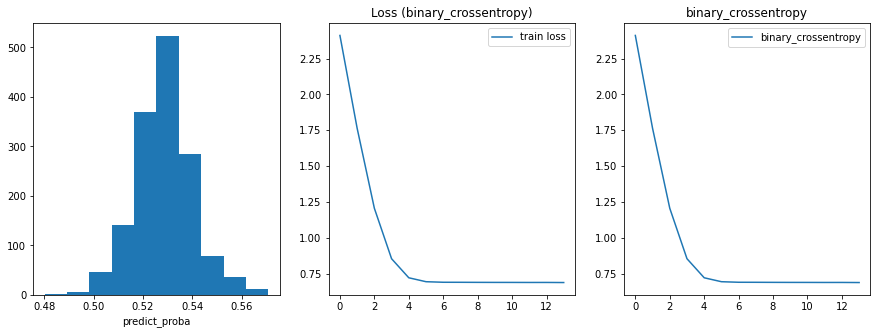

In [78]:
run_model(model_function=single_node_model, lr=0.001,
          loss = "binary_crossentropy", metrics = ["binary_crossentropy"],
          X = X, Y = Y_labels, epochs = 14, batch_size = 32, verbose = False, shuffle = True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 7         
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________
None

Model Boosting took 17.781837940216064 seconds
Training Accuracy = 84.33%
Counter({1: 1037, 0: 463})


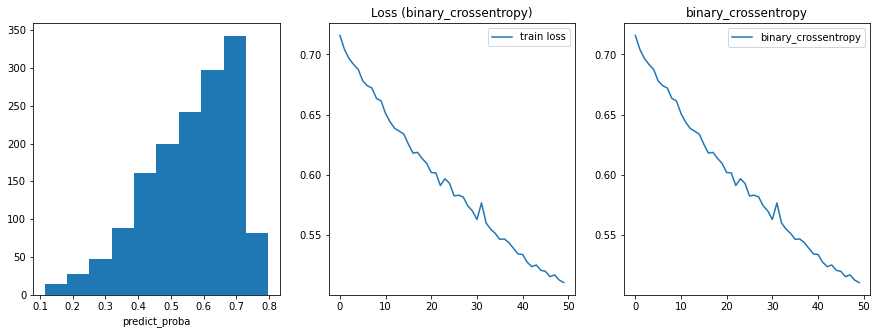

In [79]:
run_model(model_function=single_node_model, lr=0.01,
          loss = "binary_crossentropy", metrics = ["binary_crossentropy"],
          X = X, Y = Y_labels, epochs = 50, batch_size = 32, verbose = False, shuffle = True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 6)                 0         
_________________________________________________________________
dense (Dense)                (None, 32)                224       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_3 (Dropout)          (None, 8)                 0

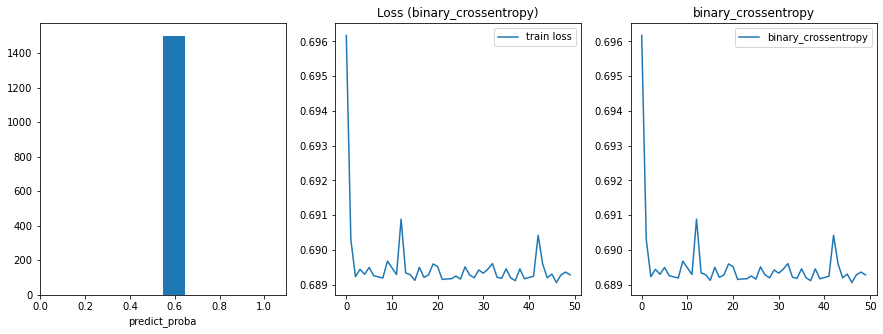

In [80]:
run_model(model_function=labeling_booster_model, lr=0.01,
          loss = "binary_crossentropy", metrics = ["binary_crossentropy"],
          X = X, Y = Y_labels, epochs = 50, batch_size = 32, verbose = False, shuffle = True)

In [25]:
def building_model(input_shape=None, loss=bin_cross_v0, metrics=None, lr=0.1):
    if metrics is None:
        metrics = [loss]
    
    model = Sequential()
    model.add(Dense(units=32, activation="relu", input_shape=(input_shape,)))
    model.add(Dense(units=16, activation="relu"))
    model.add(Dense(units=8, activation="relu"))
#     model.add(Dense(units=4, activation="relu"))

    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(loss=loss, optimizer=Adam(lr=lr),
                  metrics=metrics, run_eagerly=True)
    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                224       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
47/47 [==============================] - 1s 11ms/step - loss: 0.7150 - binary_crossentropy: 0.7150
Epoch 2/50
47/47 [==============================] - 1s 11ms/step - loss: 0.6878 - binary_crossentropy: 0.6878
Epoch 3/50
47/47 [=============

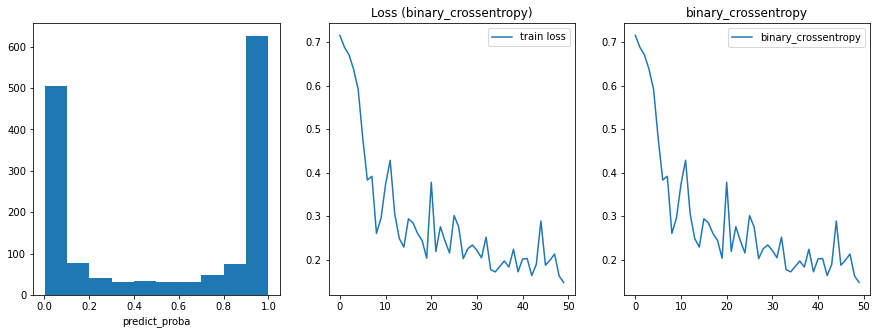

In [26]:
run_model(model_function=building_model, lr=0.01,
          loss = "binary_crossentropy", metrics = ["binary_crossentropy"],
          X = X, Y = Y_labels, epochs = 50, batch_size = 32, verbose = True, shuffle = True)

In [55]:
def building_model_2(input_shape=None, loss=bin_cross_v0, metrics=None, lr=0.1):
    if metrics is None:
        metrics = [loss]
    
    model = Sequential()
    model.add(Dense(units=64, activation="relu", input_shape=(input_shape,)))
    model.add(Dense(units=32, activation="relu"))
    model.add(Dense(units=16, activation="relu"))
#     model.add(Dense(units=128, activation="relu"))

    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(loss=loss, optimizer=Adam(lr=lr),
                  metrics=metrics, run_eagerly=True)
    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                448       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
47/47 [==============================] - 1s 12ms/step - loss: 0.7314 - binary_crossentropy: 0.7314
Epoch 2/50
47/47 [==============================] - 1s 12ms/step - loss: 0.6835 - binary_crossentropy: 0.6835
Epoch 3/50
47/47 [=========

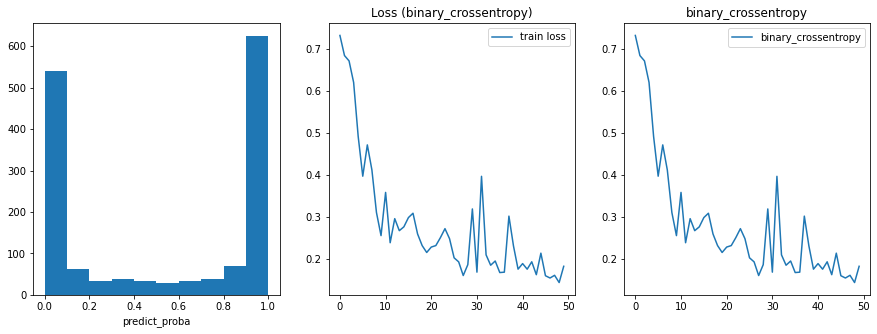

In [56]:
run_model(model_function=building_model_2, lr=0.01,
          loss = "binary_crossentropy", metrics = ["binary_crossentropy"],
          X = X, Y = Y_labels, epochs = 50, batch_size = 32, verbose = True, shuffle = True)

In [6]:
run_model(model_function=building_model, lr=0.01,
          loss = "binary_crossentropy", metrics = ["binary_crossentropy"],
          X = X, Y = Y_labels, epochs = 50, batch_size = 32, verbose = True, shuffle = True)

NameError: name 'run_model' is not defined

In [103]:
X_all = df[flow_channels]
Y_labels_all = df[n.label]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                224       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/14
2028/2028 [==============================] - 24s 12ms/step - loss: 0.2272 - binary_crossentropy: 0.2272
Epoch 2/14
2028/2028 [==============================] - 24s 12ms/step - loss: 0.1760 - binary_crossentropy: 0.1760
Epoch 3/14
2028/2028 

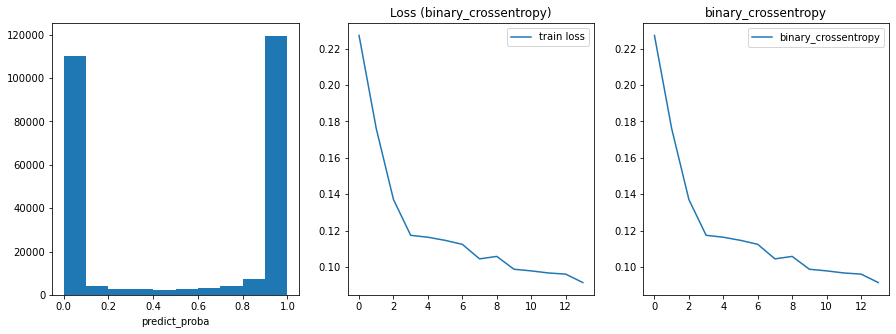

In [104]:
run_model(model_function=building_model, lr=0.01,
          loss = "binary_crossentropy", metrics = ["binary_crossentropy"],
          X = X_all, Y = Y_labels_all, epochs = 14, batch_size = 128, verbose = True, shuffle = True)